# System imbalance forecasting

Evaluate different forecasts. How accurate are they on different time horizons and how well does the accuracy translate into economic variables.  

This analysis also answers the research question **Which prediction methods obtain the most accurate result for 2h before delivery prediction of imbalance price?**

**Is the complexity of deep learning methods justified?**

**Used materials in analysis:**    
https://faculty.washington.edu/ezivot/econ584/notes/unitroot.pdf  
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3  
Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 10.04.2022  
https://www.statsmodels.org/stable/tsa.html  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math, copy, time
import seaborn

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse, meanabs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from  sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# pip install pmdarima
import pmdarima as pm

/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [7]:
import warnings
warnings.filterwarnings('ignore')

## Data preparation

Original data obtained from Baltic Transparency Dashboard, via API. Script, that puts together the dataset is in `data_miner.py`

In [8]:
AGGREGATION_STEP = 60

In [9]:
def change_timeseries_aggregation_step(timeseries_df: pd.DataFrame, aggregation_step: int):
    '''
    Take univariate timeseries with 1min data and aggregate.
    :param timeseries:
    :param aggregation_step:
    :return:
    '''
    n_count = timeseries_df.shape[0]
    n_count_aggregated = round(n_count / aggregation_step)
    new_entries = {'from': [], 'aggregate': []}
    for i in range(0, n_count, aggregation_step):
        chunk = timeseries_df.iloc[i:(i + aggregation_step), :]
        aggregate = (chunk.iloc[:, 1].mean())

        new_entry_timestamp = str(chunk.index[0]).split('+')[0]
        new_entries['from'].append(new_entry_timestamp)
        new_entries['aggregate'].append(aggregate)
    aggregated_df = pd.DataFrame(data=new_entries)
    return aggregated_df

In [10]:
df_timeseries = pd.read_csv('imbalance_state_mwh_2021-05-01T21:00.csv', index_col=1, parse_dates=True)
df_timeseries.drop(['Unnamed: 0', 'to'], inplace=True, axis=1)

df_timeseries = change_timeseries_aggregation_step(df_timeseries, AGGREGATION_STEP)
df_timeseries['from'] = pd.to_datetime(df_timeseries['from'])
df_timeseries.index = df_timeseries.iloc[:, 0]  # Change the col to index with datetimes, instead of integers!
df_timeseries.drop('from', axis=1, inplace=True) 

df_timeseries

,aggregate
from,
2021-05-05 07:00:00,-20.351083
2021-05-05 08:00:00,-82.104183
2021-05-05 09:00:00,-66.771317
2021-05-05 10:00:00,-111.531850
2021-05-05 11:00:00,-73.331417
...,...
2022-04-09 13:00:00,50.164933
2022-04-09 14:00:00,39.902317
2022-04-09 15:00:00,52.433817


## Models

1) ARIMA timeseries models  
2) LSTM neural network model  
3) Transformer neural network model  

---

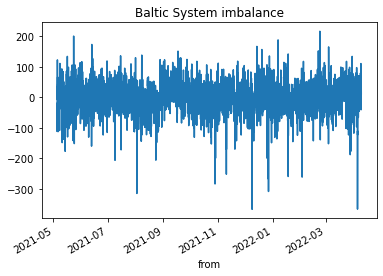

In [11]:
df_timeseries['aggregate'].dropna().plot(title='Baltic System imbalance')
plt.show()

## 1. Statistical methods 

In this section, we look at the classical statistical methods for timeseries forecating. Specifically the Box-Jenkins method (ARIMA) and Exponential smoothing method.

## 1.1 ARIMA (Autoregressive Integrated Moving Average)

In order to find suitable model, I follow Box-Jenkins method. ARIMA model requires to define the AR, I and MA terms.  
**Steps:**  

0) Is the timeseries stationary? Stationarity guarantees, that the statistical characteristics will be similar in different times (strong - The random process PDF is the same at any $t$, weak - Random process characteristics (mean and variance are the same at any $t$.    

I use ADF Unit Root test, in order to objectively identify, whether the process has unit root ($|\phi| < 1$). The alternative test for  unit-root, is Phillips- Perron. The test statistic differs from the ADF, by ignoring all the serial correlation in test-regression (https://faculty.washington.edu/ezivot/econ584/notes/unitroot.pdf). This makes it prone to heteroscedacity.  

In addition, I use stationarity test KPSS (Kwiatkowski-Phillips-Schmidt-Shin), to see if ...

1) Determine the order of AR and MA terms first, by visually, looking at ACF and PACF plots - the ARIMA model should remove all autocorrelation structures from the timeseries, so the resulting model residuals do not have any autocorrelation structure (Box-Ljung Q-statistic test)   

2) Check the AIC criterions of models.  
3) 

Augmented Dickey-Fuller test statistic

$$y_t = \beta D_t + \phi y_{t-1} + \sum^{p}_{j=1}\psi_j\Delta y_{t-j} + \epsilon_t$$ 
where  
$D$ - Deterministic trend and constant  
$\beta$ - Regression model estimates (evaluated, using OLS)  


In [12]:
result_adf = adfuller(df_timeseries['aggregate'].dropna())
critical_value = result_adf[4]['5%']
adf_stat = result_adf[0]

print(f"p-value: {result_adf[1]}")
print(f"Used lags: {result_adf[2]}")

if adf_stat < critical_value:
    print("H1: (the timeseries are difference stationary, the process has unit root)")
else:
    print("H0: The process is not stationary!")

p-value: 1.4541034372564362e-19
Used lags: 28
H1: (the timeseries are difference stationary, the process has unit root)


Test statistic for KPSS test: $$y_t = \beta D_t + \mu_t + u_t$$, where  
$D$ - Deterministic trend and constant  
$\beta$ - Regression model estimates (evaluated, using OLS)  
$$\mu_t = \mu_{t-1} + \epsilon_t, \epsilon_t \sim W N(0, \sigma^2_\epsilon)$$


In [13]:
result_kpss = kpss(df_timeseries['aggregate'].dropna(), nlags='auto')

critical_value = result_kpss[3]['5%']
kpss_stat = result_kpss[0]

print(f"p-value: {result_kpss[1]}")
print(f"Used lags: {result_kpss[2]}")
print(critical_value)
print(kpss_stat)

if kpss_stat > critical_value:
    print("H1: the timeseries are not trend stationary")
else:
    print("H0: the timeseries are trend stationary")

p-value: 0.1
Used lags: 42
0.463
0.19333876778479195
H0: the timeseries are trend stationary


Look for autocorrelation visual patterns on ACF and PACF plots

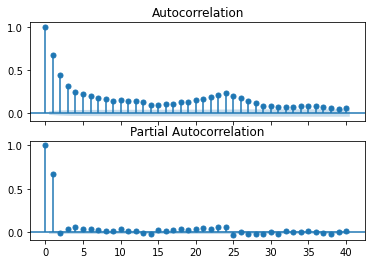

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True)
plot_acf(df_timeseries['aggregate'].dropna(), ax=axes[0])
plot_pacf(df_timeseries['aggregate'].dropna(), ax=axes[1])
plt.show()

From the ACF&PACF plots, we can assume, that the process is probably AR(2), but to verify it, we calculate the AIC information criterion.  
$$\text{AIC} = -2 \log(L) + 2(p+q+k+1)$$

Test the following models:  
1) ARMA(1, 0)  
2) ARMA(2, 0)  
3) ARMA(3, 0)  
4) ARMA(2, 1)  
5) ARMA(2, 2)  
6) ARMA(3, 1)  
7) ARMA(3, 2)  

In [15]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(1, 0, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -40179.097
Date:                Mon, 11 Apr 2022   AIC                          80364.193
Time:                        19:06:41   BIC                          80385.208
Sample:                             0   HQIC                         80371.380
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6148      1.177     -0.522      0.601      -2.922       1.692
ar.L1          0.6675      0.005    130.541      0.000       0.657       0.677
sigma2      1130.6258      7.990    141.513      0.000    1114.966    1146.285
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             29855.52
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(2, 0, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -40178.871
Date:                Mon, 11 Apr 2022   AIC                          80365.742
Time:                        19:06:41   BIC                          80393.762
Sample:                             0   HQIC                         80375.325
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6149      1.168     -0.526      0.599      -2.905       1.675
ar.L1          0.6724      0.006    111.604      0.000       0.661       0.684
ar.L2         -0.0074      0.007     -1.043      0.297      -0.021       0.007
sigma2      1130.1329      8.001    141.256      0.000    1114.452    1145.814
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             30010.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.73
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(3, 0, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -40174.253
Date:                Mon, 11 Apr 2022   AIC                          80358.506
Time:                        19:06:42   BIC                          80393.530
Sample:                             0   HQIC                         80370.483
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6148      1.209     -0.509      0.611      -2.984       1.754
ar.L1          0.6726      0.006    111.598      0.000       0.661       0.684
ar.L2         -0.0301      0.009     -3.506      0.000      -0.047      -0.013
ar.L3          0.0337      0.009      3.884      0.000       0.017       0.051
sigma2      1128.9703      7.988    141.334      0.000    1113.314    1144.626
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             30072.77
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.73
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(2, 0, 1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -40178.437
Date:                Mon, 11 Apr 2022   AIC                          80366.875
Time:                        19:06:45   BIC                          80401.899
Sample:                             0   HQIC                         80378.852
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6155      1.168     -0.527      0.598      -2.905       1.674
ar.L1          0.3427      0.597      0.574      0.566      -0.827       1.512
ar.L2          0.2101      0.400      0.525      0.600      -0.574       0.995
ma.L1          0.3328      0.596      0.559      0.576      -0.834       1.500
sigma2      1130.3455      8.003    141.242      0.000    1114.660    1146.031
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             30113.14
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                        12.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(2, 0, 2))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -40112.801
Date:                Mon, 11 Apr 2022   AIC                          80237.603
Time:                        19:06:50   BIC                          80279.632
Sample:                             0   HQIC                         80251.976
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6180      2.642     -0.234      0.815      -5.796       4.560
ar.L1          1.5349      0.017     92.468      0.000       1.502       1.567
ar.L2         -0.5419      0.015    -35.343      0.000      -0.572      -0.512
ma.L1         -0.8786      0.017    -51.160      0.000      -0.912      -0.845
ma.L2         -0.0737      0.012     -6.103      0.000      -0.097      -0.050
sigma2      1112.1799      7.900    140.787      0.000    1096.697    1127.663
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             30639.62
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.75
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(3, 0, 1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -40112.475
Date:                Mon, 11 Apr 2022   AIC                          80236.949
Time:                        19:06:56   BIC                          80278.979
Sample:                             0   HQIC                         80251.323
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6168      2.623     -0.235      0.814      -5.758       4.524
ar.L1          1.6117      0.010    158.127      0.000       1.592       1.632
ar.L2         -0.6664      0.012    -55.554      0.000      -0.690      -0.643
ar.L3          0.0480      0.008      6.362      0.000       0.033       0.063
ma.L1         -0.9545      0.008   -116.275      0.000      -0.971      -0.938
sigma2      1112.1384      7.904    140.714      0.000    1096.648    1127.629
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             30648.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.75
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=(3, 0, 2))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              aggregate   No. Observations:                 8143
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -40137.333
Date:                Mon, 11 Apr 2022   AIC                          80288.666
Time:                        19:07:03   BIC                          80337.700
Sample:                             0   HQIC                         80305.434
                               - 8143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6175      1.499     -0.412      0.680      -3.555       2.320
ar.L1          1.9891      0.141     14.139      0.000       1.713       2.265
ar.L2         -1.3388      0.221     -6.062      0.000      -1.772      -0.906
ar.L3          0.3222      0.083      3.866      0.000       0.159       0.486
ma.L1         -1.3174      0.142     -9.299      0.000      -1.595      -1.040
ma.L2          0.4232      0.132      3.194      0.001       0.164       0.683
sigma2      1114.3271      7.984    139.571      0.000    1098.679    1129.975
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):             30086.03
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.74
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From models with all statistically significant parameters, select the model with the **Lowest** AIC value

In [22]:
orders = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (2, 0, 1), (2, 0, 2), (3, 0, 1), (3, 0, 2)]

In [23]:
aicc_values = []
for order in orders:
    model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=order)
    fitted = model.fit()
    aic_value = fitted.aicc
    aicc_values.append(aic_value)


In [24]:
min_idx = np.argmin(aicc_values)
print(f"Best model: {orders[min_idx]}")

# Select the best
model = sm.tsa.arima.ARIMA(df_timeseries['aggregate'].dropna(), order=orders[min_idx])
fitted = model.fit()

Best model: (3, 0, 1)


See, if the residuals are white noise (no autocorrelation)

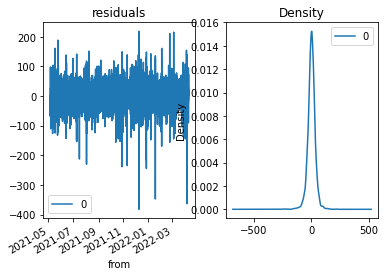

In [25]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title='residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

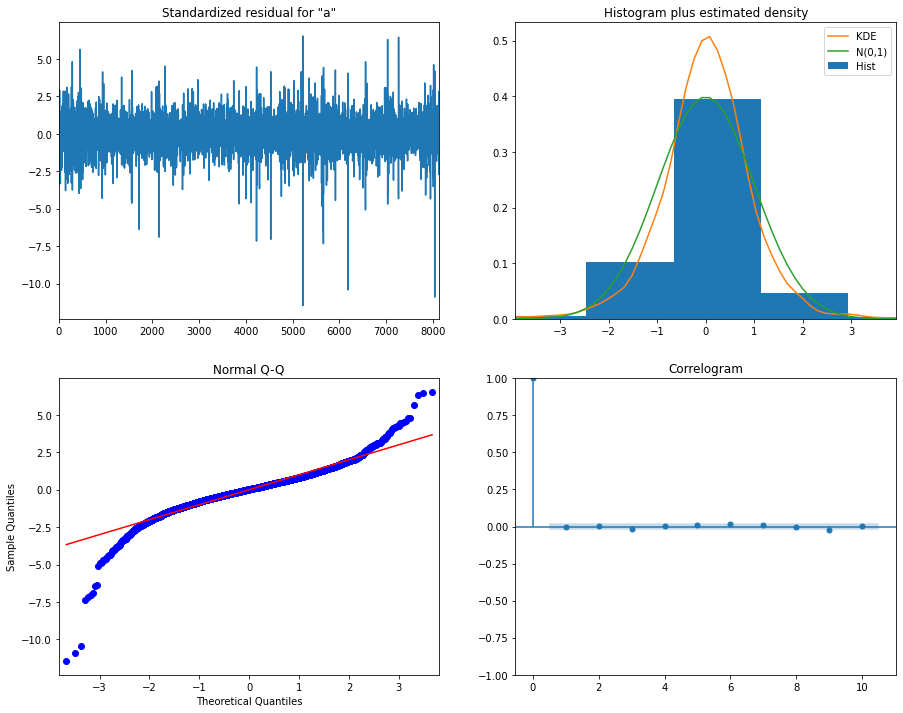

In [26]:
fitted.plot_diagnostics(figsize=(15, 12))
plt.show()

* The tails of the KDE are relatively not-heavy, which is suprising, considering, that most of the real processes have heavy tails  
* The correlogram shows, that the autocorrelation structure is removed and residuals are mostly white noise (MA(0) process) 

## Validation 

Validate the model, and analyze the results of different forecast horizons. Use cross-validation as a validation method and RMSE and MAPE as metrics.  

Since the results of tests described above gave results, that timeseries are stationary, we can take use parts of the original series as training-test data, as the probability distribution must be the same. 

The **error** is different from residuals, in a way that residuals are for training errors, but error considers test data. 
$$e_{T+h} = y_{T+h} - \hat{y}_{T+h|T}$$

where $T$ is the size of training data

Time series data is harder to cross-validate, because of the sequential nature

In [29]:
from sklearn.model_selection import TimeSeriesSplit

# Returns 10 folds of [training], test 
tscv = TimeSeriesSplit(n_splits=10)
for train_idx, test_idx in tscv.split(train):
    X_train, X_test = df_timeseries.iloc[train_idx], df_timeseries.iloc[test_idx]
#     y_train, y_test = df_timeseries[train_idx], df_timeseries[test_idx]

    print("TRAIN:", X_train)
    print()
    print("TEST:", X_test)

    model = sm.tsa.arima.ARIMA(X_train['aggregate'].dropna(), order=(3, 0, 1))
    fitted = model.fit()
    
    fitted.get_prediction(start=X_test.index[0], end=X_test.index[-1], dynamic=False)
    


TRAIN:                       aggregate
from                           
2021-05-05 07:00:00  -20.351083
2021-05-05 08:00:00  -82.104183
2021-05-05 09:00:00  -66.771317
2021-05-05 10:00:00 -111.531850
2021-05-05 11:00:00  -73.331417
...                         ...
2021-05-29 23:00:00   12.418067
2021-05-30 00:00:00   -6.635250
2021-05-30 01:00:00    5.963200
2021-05-30 02:00:00  -21.146617
2021-05-30 03:00:00    3.301850

[597 rows x 1 columns]

TEST:                      aggregate
from                          
2021-05-30 04:00:00  28.686033
2021-05-30 05:00:00  15.517100
2021-05-30 06:00:00  26.703733
2021-05-30 07:00:00   1.053550
2021-05-30 08:00:00  15.658150
...                        ...
2021-06-23 15:00:00  62.557050
2021-06-23 16:00:00  72.244900
2021-06-23 17:00:00  71.431800
2021-06-23 18:00:00  93.252550
2021-06-23 19:00:00  13.902317

[592 rows x 1 columns]
TRAIN:                       aggregate
from                           
2021-05-05 07:00:00  -20.351083
2021-05-05 08:00

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

### Naive baseline model

The more complicated models must perform better than the naive baseline. Naive baseline forecast just last seen value.

In [354]:
from sklearn.metrics import mean_squared_error


def validate_naive_forecast(train, test, steps=3):
    history = [x for x in train]
    predictions = []
    predicted_observations=[]
    reduced_test_size = steps -1

    for i in range(len(test) - reduced_test_size):
        yhat = history[-1]
        predictions.append(yhat)
        current_observation = test[i]
        predicted_observation = test[i+steps-1]
        
        predicted_observations.append(predicted_observation)
        history.append(current_observation)
        print(f'Forecast {yhat}, Actual {predicted_observation}')

    predicted_observations = np.array(predicted_observations)
    rmse = round(np.sqrt(mean_squared_error(predicted_observations, predictions)), 2)
    mape = round(np.mean(np.abs(predictions - predicted_observations)/np.abs(predicted_observations)), 2)
    mae = round(np.mean(np.abs(predictions - predicted_observations)), 2)
    
    error_metrics = {'rmse': rmse, 'mape': mape, 'mae': mae}
    return error_metrics


In [355]:
error_metrics = validate_naive_forecast(train.dropna(), test.dropna())
print("Naive forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

Forecast 37.31456666666667, Actual 15.855950000000002
Forecast 61.65790000000002, Actual 11.827966666666669
Forecast 25.291083333333333, Actual 7.8474666666666675
Forecast 15.855950000000002, Actual 34.18424999999999
Forecast 11.827966666666669, Actual 35.86436666666667
Forecast 7.8474666666666675, Actual 14.120166666666668
Forecast 34.18424999999999, Actual 39.87765
Forecast 35.86436666666667, Actual 103.4653166666667
Forecast 14.120166666666668, Actual -56.25700000000002
Forecast 39.87765, Actual -7.663716666666668
Forecast 103.4653166666667, Actual 27.58543333333332
Forecast -56.25700000000002, Actual -6.724233333333334
Forecast -7.663716666666668, Actual -1.944233333333336
Forecast 27.58543333333332, Actual -44.60943333333333
Forecast -6.724233333333334, Actual -74.08079999999998
Forecast -1.944233333333336, Actual -56.31776666666666
Forecast -44.60943333333333, Actual -37.77403333333333
Forecast -74.08079999999998, Actual -7.396016666666666
Forecast -56.31776666666666, Actual 17.9

In [349]:
test

from
2022-03-06 19:00:00    61.657900
2022-03-06 20:00:00    25.291083
2022-03-06 21:00:00    15.855950
2022-03-06 22:00:00    11.827967
2022-03-06 23:00:00     7.847467
                         ...    
2022-04-09 13:00:00    50.164933
2022-04-09 14:00:00    39.902317
2022-04-09 15:00:00    52.433817
2022-04-09 16:00:00    34.197683
2022-04-09 17:00:00    11.900102
Name: aggregate, Length: 815, dtype: float64

Get ARIMA error metrics. To reduce time, don't refit the model in every step as this would be unnecessary

In [217]:
def train_test_split(data, train_size):
    x_len = data.shape[0]
    train_size = int(x_len * train_size)

    train = data.iloc[:train_size, data.columns.get_loc('aggregate')]
    test = data.iloc[train_size:, data.columns.get_loc('aggregate')]
    return train, test

In [319]:
def validate_arima_forecast(fitted, train, test, steps=1) -> dict():
    """
    For each step predict the "steps" new observations. Add up the prediction errors.
    Error is for the whole length of the test data (same length in every validation, to compare metrics)
    
    :param fitted: ARIMAResults fitted model.
    """
    
    predictions = []
    test = test.values
    reduced_test_size = steps -1
    
    for i in range(len(test) - reduced_test_size):
        
        yhat = fitted.forecast(steps)[-1]
        predictions.append(yhat)  # Take the value corresponding to forecast horizon.
        
        refit=False
        # It is not necessary, to refit every time, but every 20 times will be optimal.
        if i % 20 ==0:
            refit=True
        
        # We add 1 observation value at every step, not depending on forecast horizon!
        observation = df_timeseries[len(fitted.fittedvalues):len(fitted.fittedvalues)+steps]
        print('observation',observation)
        
        fitted = fitted.append(observation.iloc[:-1], refit=refit)  # ARIMAResults object append. D
        
#         print(len(fitted.fittedvalues))
#         print(f'>Forecast{yhat}, Actual={observation.iloc[-1, 0]}')
    print(len(predictions))
    test= test[:-1]
    rmse = round(np.sqrt(mean_squared_error(test, predictions)), 2)
    mape = round(np.mean(np.abs(predictions - test)/np.abs(test)), 2)
    mae = round(np.mean(np.abs(predictions - test)), 2)
    
    error_metrics = {'rmse': rmse, 'mape': mape, 'mae': mae}

    return error_metrics, predictions
    

<AxesSubplot:xlabel='from'>

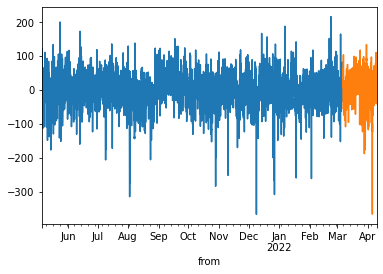

In [325]:
train, test = train_test_split(df_timeseries, 0.9)
model = sm.tsa.arima.ARIMA(train, order=(3, 0, 1))
fitted = model.fit()
train.plot()
test.plot()

In [326]:
error_metrics, predictions = validate_arima_forecast(fitted, train.dropna(), test.dropna(), steps=2)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

observation                      aggregate
from                          
2022-03-06 19:00:00  61.657900
2022-03-06 20:00:00  25.291083
observation                      aggregate
from                          
2022-03-06 20:00:00  25.291083
2022-03-06 21:00:00  15.855950
observation                      aggregate
from                          
2022-03-06 21:00:00  15.855950
2022-03-06 22:00:00  11.827967
observation                      aggregate
from                          
2022-03-06 22:00:00  11.827967
2022-03-06 23:00:00   7.847467
observation                      aggregate
from                          
2022-03-06 23:00:00   7.847467
2022-03-07 00:00:00  34.184250
observation                      aggregate
from                          
2022-03-07 00:00:00  34.184250
2022-03-07 01:00:00  35.864367
observation                      aggregate
from                          
2022-03-07 01:00:00  35.864367
2022-03-07 02:00:00  14.120167
observation                      aggregate
from 

observation                       aggregate
from                           
2022-03-09 08:00:00 -106.245050
2022-03-09 09:00:00  -94.547733
observation                      aggregate
from                          
2022-03-09 09:00:00 -94.547733
2022-03-09 10:00:00 -20.850500
observation                      aggregate
from                          
2022-03-09 10:00:00 -20.850500
2022-03-09 11:00:00  40.180767
observation                      aggregate
from                          
2022-03-09 11:00:00  40.180767
2022-03-09 12:00:00   4.205050
observation                      aggregate
from                          
2022-03-09 12:00:00   4.205050
2022-03-09 13:00:00  -2.181267
observation                      aggregate
from                          
2022-03-09 13:00:00  -2.181267
2022-03-09 14:00:00   5.626550
observation                      aggregate
from                          
2022-03-09 14:00:00   5.626550
2022-03-09 15:00:00 -24.641433
observation                      aggregate
f

observation                      aggregate
from                          
2022-03-12 00:00:00  -2.263617
2022-03-12 01:00:00  -7.432283
observation                      aggregate
from                          
2022-03-12 01:00:00  -7.432283
2022-03-12 02:00:00 -14.655350
observation                      aggregate
from                          
2022-03-12 02:00:00 -14.655350
2022-03-12 03:00:00 -45.326117
observation                      aggregate
from                          
2022-03-12 03:00:00 -45.326117
2022-03-12 04:00:00 -26.311400
observation                      aggregate
from                          
2022-03-12 04:00:00 -26.311400
2022-03-12 05:00:00 -12.357817
observation                      aggregate
from                          
2022-03-12 05:00:00 -12.357817
2022-03-12 06:00:00 -51.173133
observation                      aggregate
from                          
2022-03-12 06:00:00 -51.173133
2022-03-12 07:00:00 -95.507783
observation                      aggregate
from 

observation                      aggregate
from                          
2022-03-14 16:00:00  22.946183
2022-03-14 17:00:00   9.910367
observation                      aggregate
from                          
2022-03-14 17:00:00   9.910367
2022-03-14 18:00:00  11.587300
observation                      aggregate
from                          
2022-03-14 18:00:00  11.587300
2022-03-14 19:00:00   0.863717
observation                      aggregate
from                          
2022-03-14 19:00:00   0.863717
2022-03-14 20:00:00   3.445450
observation                      aggregate
from                          
2022-03-14 20:00:00    3.44545
2022-03-14 21:00:00   23.95620
observation                      aggregate
from                          
2022-03-14 21:00:00  23.956200
2022-03-14 22:00:00   5.776533
observation                      aggregate
from                          
2022-03-14 22:00:00   5.776533
2022-03-14 23:00:00  17.924500
observation                      aggregate
from 

observation                      aggregate
from                          
2022-03-17 08:00:00   6.426800
2022-03-17 09:00:00  38.684833
observation                      aggregate
from                          
2022-03-17 09:00:00  38.684833
2022-03-17 10:00:00  32.955850
observation                      aggregate
from                          
2022-03-17 10:00:00  32.955850
2022-03-17 11:00:00  17.746983
observation                      aggregate
from                          
2022-03-17 11:00:00  17.746983
2022-03-17 12:00:00  15.892500
observation                      aggregate
from                          
2022-03-17 12:00:00  15.892500
2022-03-17 13:00:00 -30.719167
observation                      aggregate
from                          
2022-03-17 13:00:00 -30.719167
2022-03-17 14:00:00 -56.230650
observation                      aggregate
from                          
2022-03-17 14:00:00 -56.230650
2022-03-17 15:00:00 -11.447083
observation                      aggregate
from 

observation                      aggregate
from                          
2022-03-19 23:00:00  54.119000
2022-03-20 00:00:00  96.869033
observation                      aggregate
from                          
2022-03-20 00:00:00  96.869033
2022-03-20 01:00:00  54.668700
observation                      aggregate
from                          
2022-03-20 01:00:00  54.668700
2022-03-20 02:00:00  46.246817
observation                      aggregate
from                          
2022-03-20 02:00:00  46.246817
2022-03-20 03:00:00  42.472633
observation                      aggregate
from                          
2022-03-20 03:00:00  42.472633
2022-03-20 04:00:00  59.115650
observation                      aggregate
from                          
2022-03-20 04:00:00  59.115650
2022-03-20 05:00:00  60.991183
observation                      aggregate
from                          
2022-03-20 05:00:00  60.991183
2022-03-20 06:00:00  55.433367
observation                      aggregate
from 

observation                      aggregate
from                          
2022-03-22 12:00:00  31.370967
2022-03-22 13:00:00  -3.632383
observation                      aggregate
from                          
2022-03-22 13:00:00  -3.632383
2022-03-22 14:00:00 -12.897700
observation                      aggregate
from                          
2022-03-22 14:00:00  -12.89770
2022-03-22 15:00:00   11.70785
observation                      aggregate
from                          
2022-03-22 15:00:00  11.707850
2022-03-22 16:00:00  86.263133
observation                      aggregate
from                          
2022-03-22 16:00:00  86.263133
2022-03-22 17:00:00  77.660950
observation                      aggregate
from                          
2022-03-22 17:00:00  77.660950
2022-03-22 18:00:00  69.540367
observation                      aggregate
from                          
2022-03-22 18:00:00  69.540367
2022-03-22 19:00:00  81.027900
observation                      aggregate
from 

observation                      aggregate
from                          
2022-03-25 03:00:00  50.348367
2022-03-25 04:00:00  58.970733
observation                      aggregate
from                          
2022-03-25 04:00:00  58.970733
2022-03-25 05:00:00  52.416317
observation                      aggregate
from                          
2022-03-25 05:00:00  52.416317
2022-03-25 06:00:00  33.124683
observation                      aggregate
from                          
2022-03-25 06:00:00  33.124683
2022-03-25 07:00:00  15.106900
observation                      aggregate
from                          
2022-03-25 07:00:00   15.10690
2022-03-25 08:00:00  -55.90475
observation                       aggregate
from                           
2022-03-25 08:00:00  -55.904750
2022-03-25 09:00:00 -104.222117
observation                       aggregate
from                           
2022-03-25 09:00:00 -104.222117
2022-03-25 10:00:00  -37.939733
observation                      aggrega

observation                      aggregate
from                          
2022-03-27 16:00:00  98.164767
2022-03-27 17:00:00  15.839617
observation                      aggregate
from                          
2022-03-27 17:00:00  15.839617
2022-03-27 18:00:00  43.702250
observation                      aggregate
from                          
2022-03-27 18:00:00  43.702250
2022-03-27 19:00:00  19.104617
observation                      aggregate
from                          
2022-03-27 19:00:00  19.104617
2022-03-27 20:00:00  -3.597733
observation                      aggregate
from                          
2022-03-27 20:00:00  -3.597733
2022-03-27 21:00:00   0.808383
observation                      aggregate
from                          
2022-03-27 21:00:00   0.808383
2022-03-27 22:00:00  26.506450
observation                      aggregate
from                          
2022-03-27 22:00:00  26.506450
2022-03-27 23:00:00  40.721617
observation                      aggregate
from 

observation                      aggregate
from                          
2022-03-30 04:00:00  44.059683
2022-03-30 05:00:00  -6.471017
observation                      aggregate
from                          
2022-03-30 05:00:00  -6.471017
2022-03-30 06:00:00  13.119700
observation                      aggregate
from                          
2022-03-30 06:00:00    13.1197
2022-03-30 07:00:00   -10.5855
observation                      aggregate
from                          
2022-03-30 07:00:00 -10.585500
2022-03-30 08:00:00 -20.796567
observation                      aggregate
from                          
2022-03-30 08:00:00 -20.796567
2022-03-30 09:00:00   7.231650
observation                      aggregate
from                          
2022-03-30 09:00:00    7.23165
2022-03-30 10:00:00   42.42185
observation                      aggregate
from                          
2022-03-30 10:00:00  42.421850
2022-03-30 11:00:00  31.054433
observation                      aggregate
from 

observation                      aggregate
from                          
2022-04-01 20:00:00 -30.747667
2022-04-01 21:00:00 -54.295650
observation                      aggregate
from                          
2022-04-01 21:00:00 -54.295650
2022-04-01 22:00:00  48.539033
observation                      aggregate
from                          
2022-04-01 22:00:00  48.539033
2022-04-01 23:00:00  32.679233
observation                      aggregate
from                          
2022-04-01 23:00:00  32.679233
2022-04-02 00:00:00   7.399600
observation                      aggregate
from                          
2022-04-02 00:00:00   7.399600
2022-04-02 01:00:00 -10.996567
observation                      aggregate
from                          
2022-04-02 01:00:00 -10.996567
2022-04-02 02:00:00 -10.141233
observation                      aggregate
from                          
2022-04-02 02:00:00 -10.141233
2022-04-02 03:00:00   1.427283
observation                      aggregate
from 

observation                      aggregate
from                          
2022-04-04 12:00:00 -96.714450
2022-04-04 13:00:00  97.136417
observation                      aggregate
from                          
2022-04-04 13:00:00  97.136417
2022-04-04 14:00:00   8.390133
observation                      aggregate
from                          
2022-04-04 14:00:00   8.390133
2022-04-04 15:00:00  -4.421333
observation                      aggregate
from                          
2022-04-04 15:00:00  -4.421333
2022-04-04 16:00:00  12.166183
observation                      aggregate
from                          
2022-04-04 16:00:00  12.166183
2022-04-04 17:00:00  -4.514200
observation                      aggregate
from                          
2022-04-04 17:00:00  -4.514200
2022-04-04 18:00:00  15.562417
observation                      aggregate
from                          
2022-04-04 18:00:00  15.562417
2022-04-04 19:00:00  20.364367
observation                      aggregate
from 

observation                      aggregate
from                          
2022-04-07 03:00:00  16.888717
2022-04-07 04:00:00  52.350267
observation                      aggregate
from                          
2022-04-07 04:00:00  52.350267
2022-04-07 05:00:00   7.897317
observation                      aggregate
from                          
2022-04-07 05:00:00   7.897317
2022-04-07 06:00:00  34.968733
observation                      aggregate
from                          
2022-04-07 06:00:00  34.968733
2022-04-07 07:00:00   6.678483
observation                      aggregate
from                          
2022-04-07 07:00:00   6.678483
2022-04-07 08:00:00   1.874233
observation                      aggregate
from                          
2022-04-07 08:00:00   1.874233
2022-04-07 09:00:00  19.586933
observation                      aggregate
from                          
2022-04-07 09:00:00  19.586933
2022-04-07 10:00:00  -1.378050
observation                      aggregate
from 

813
ARIMA  forecast metrics
RMSE: 36.03
MAPE: 1.31
MAE: 25.58


In [315]:
predictions

[-5.1486977123029405,
 -8.91027890965252,
 -35.44263588737157,
 -16.976069942085232,
 -20.92945801919536,
 3.271131838868838,
 12.641329715264439,
 -1.6899396618335538,
 5.815589085079639,
 13.37455909605068,
 7.334644955848811,
 16.276936446534677,
 11.455382219865102,
 24.257445510346678,
 20.048778973940706,
 9.341432447794437,
 9.990110658551002,
 13.93269821531314,
 16.665356411066835,
 7.7125873656271615,
 22.632080785346673,
 4.800434904226905,
 16.89825989755996,
 5.324297219737114,
 4.288256094986683,
 11.281805350509416,
 2.6157362075453885,
 -14.288698772324699,
 -9.877121828237017,
 5.400241116627753,
 10.716570131414743,
 10.225561719571376,
 5.823710091388998,
 30.002351080157442,
 17.688721625746552,
 26.640765908865642,
 27.02963695549163,
 19.751738866590966,
 20.324606719486308,
 21.489210261631836,
 28.650913163649864,
 26.389865361233163,
 28.70106087436323,
 18.0060239538057,
 16.325089594492184,
 6.750016078368171,
 -1.3516444431114936,
 -4.385050286634969,
 4.402

In [295]:
df_timeseries['2022-04-06']

,aggregate
from,
2022-04-06 00:00:00,-24.326817
2022-04-06 01:00:00,-17.353333
2022-04-06 02:00:00,0.919367
2022-04-06 03:00:00,32.846883
2022-04-06 04:00:00,-35.785950
2022-04-06 05:00:00,-46.878350
2022-04-06 06:00:00,-52.462233
2022-04-06 07:00:00,11.893317
2022-04-06 08:00:00,14.931800


In [314]:
train

from
2021-05-05 07:00:00    -20.351083
2021-05-05 08:00:00    -82.104183
2021-05-05 09:00:00    -66.771317
2021-05-05 10:00:00   -111.531850
2021-05-05 11:00:00    -73.331417
                          ...    
2022-04-06 03:00:00     32.846883
2022-04-06 04:00:00    -35.785950
2022-04-06 05:00:00    -46.878350
2022-04-06 06:00:00    -52.462233
2022-04-06 07:00:00     11.893317
Name: aggregate, Length: 8065, dtype: float64

In [296]:
model = sm.tsa.arima.ARIMA(train, order=(3, 0, 1))
fitted=model.fit()
prediction = fitted.forecast(2)
prediction

2022-04-06 08:00:00    3.427504
2022-04-06 09:00:00   -4.930511
Freq: H, Name: predicted_mean, dtype: float64

In [297]:

prediction_2step=prediction[1]
prediction_2step

-4.930510959835354

In [298]:
observation=df_timeseries[len(fitted.fittedvalues):len(fitted.fittedvalues)+2]
observation.iloc[:-1]

,aggregate
from,
2022-04-06 08:00:00,14.9318


In [299]:
fitted = fitted.append(observation.iloc[:-1])
prediction = fitted.forecast(2)
# updated_fitted.fittedvalues
prediction


2022-04-06 09:00:00    2.634909
2022-04-06 10:00:00   -5.148698
Freq: H, Name: predicted_mean, dtype: float64

In [300]:
fitted.fittedvalues

2021-05-05 07:00:00    -0.882552
2021-05-05 08:00:00   -13.880203
2021-05-05 09:00:00   -55.375087
2021-05-05 10:00:00   -43.172566
2021-05-05 11:00:00   -74.919904
                         ...    
2022-04-06 04:00:00    14.478659
2022-04-06 05:00:00   -31.583273
2022-04-06 06:00:00   -35.544453
2022-04-06 07:00:00   -38.891111
2022-04-06 08:00:00     3.427504
Freq: H, Length: 8066, dtype: float64

In [128]:
observation = df_timeseries[len(fitted.fittedvalues):len(fitted.fittedvalues)+1]
fitted = fitted.append(observation)
fitted.forecast(1)


ARIMA  forecast metrics
RMSE: 47.04
MAPE: 0.94
MAE: 37.03


In [ ]:
pred.predicted_mean

In [ ]:
ax = test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Imbalance')
plt.legend()

plt.show()

In [ ]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):
        
        
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        
        obs = test[i]
        history.append(obs)
        # calculate out of sample error
        print('>Forecast=%.3f, Actual=%3.f' % (yhat, ))
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
evaluate_arima_model(df_timeseries['aggregate'], (3, 0, 1))

In [ ]:
# Out of sample forecast
fitted.forecast(100, alpha=0.1).plot()

In [ ]:
# pred=fitted.get_prediction(steps=10, dynamic=False)

# pred_ci= pred.conf_int()

# ax = train[train_size:].plot(label='observed')
# pred.predicted_mean[train_size:].plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index[train_size:],
#                 pred_ci.iloc[train_size:, 0],
#                 pred_ci.iloc[train_size:, 1], color='k', alpha=.2)

In [ ]:
forecast= fitted.get_forecast(len(test), alpha=0.05)

In [ ]:
conf_int = forecast.conf_int()

In [ ]:
# Make as pandas series
forecast_series = pd.Series(forecast.predicted_mean, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# model_auto = pm.auto_arima(df_timeseries['aggregate'].dropna(), start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=24,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=True,   # No Seasonality
#                       start_P=0, 
#                       D=1, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

In [ ]:
# prediction = fitted.get_prediction(steps=2, )

In [ ]:
result = seasonal_decompose(df_timeseries.dropna(), model='additive')
result.plot()
plt.show()